## Imports modules

In [1]:
import numpy as np

# to get and read data
import os
import requests
import pickle

# to plot the data
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to track progress
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## get and read data

get data

In [2]:
# download zip

if not os.path.exists('anamoly_dataset.pickle'):
    url = 'https://drive.google.com/u/0/uc?id=1CdYxeX8g9wxzSnz6R51ELmJJuuZ3xlqa&export=download'
    r = requests.get(url, allow_redirects=True)
    open('anamoly_dataset.pickle', 'wb').write(r.content)
    print('file downloaded')
else:
    print('file already exists')

file downloaded


read data

In [3]:
infile = open('anamoly_dataset.pickle','rb')
data = pickle.load(infile)
infile.close()

features = 3
train_data = [ [ [input[:,i] for i in range(features) ], label ] for input,label in zip(data[0],data[1]) ]
test_data = [ [ [ input[:,i] for i in range(features) ], label ] for input,label in zip(data[2],data[3]) ]

train_inputs, train_labels = list(zip(*train_data))
test_inputs, test_labels = list(zip(*test_data))

train_inputs = np.array(train_inputs)
test_inputs = np.array(test_inputs)

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

In [46]:
classes = ["normal","anamoly"]
sample_len = 50
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')
print('length of each channel is', sample_len)

number of classes : 2

train data contains 50000 samples
test data contains 10000 samples

each sample has 3 channels : x,y and force
length of each channel is 50


function to plot sample

In [41]:
def plot_sample(sample):
    
    pressure  = sample[0]
    temperature  = sample[1]
    torque  = sample[2]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(pressure);     ax1.set_title("pressure")
    ax2.plot(temperature);  ax2.set_title("temperature")
    ax3.plot(torque);       ax3.set_title("torque")

    plt.show()

visualize one sample of each class

normal


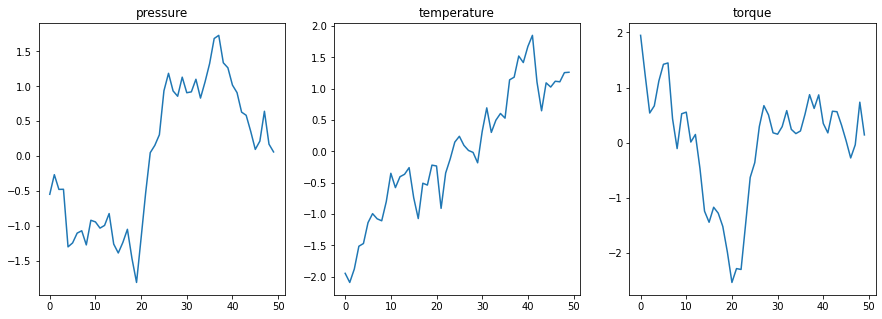

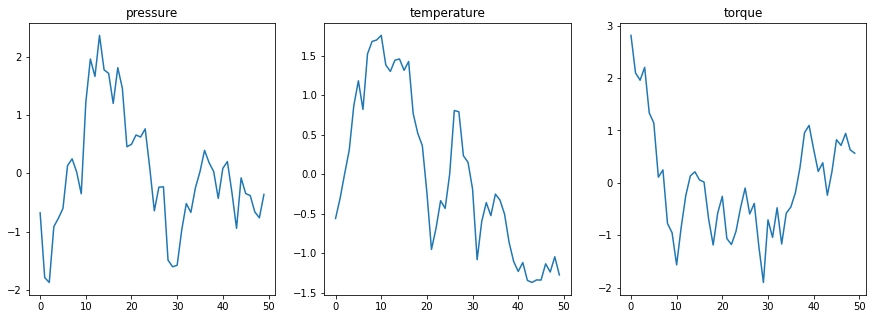

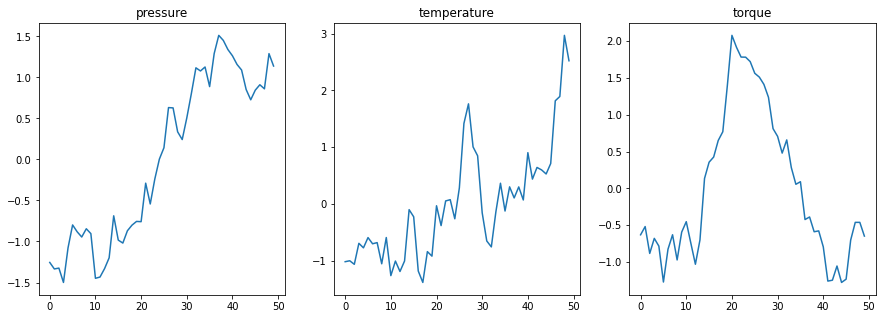

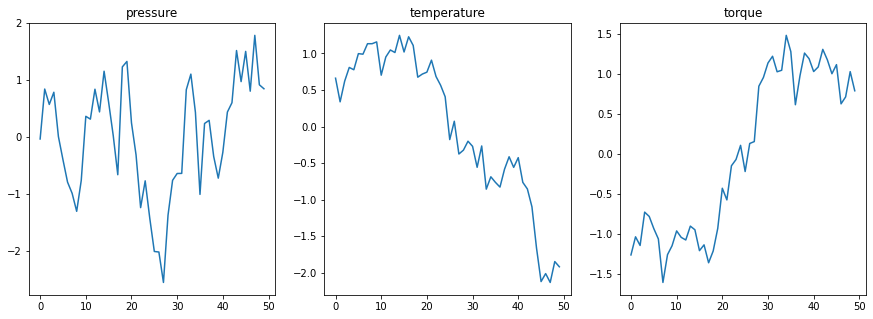

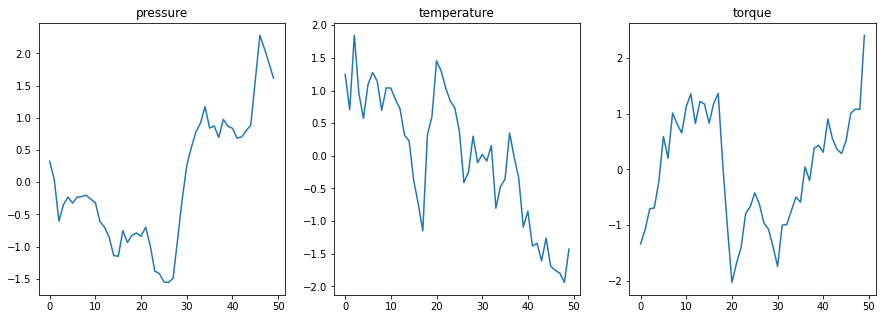

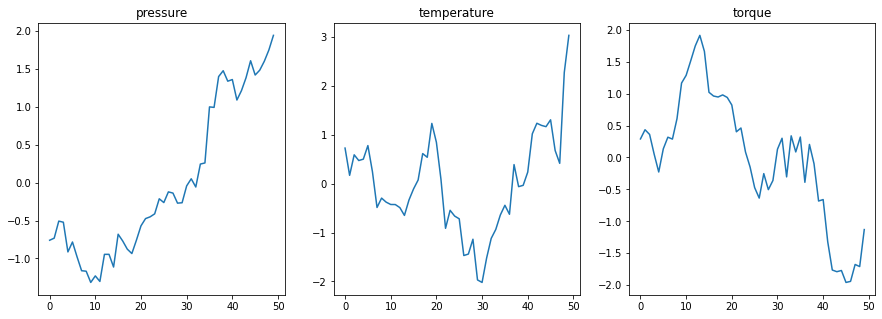

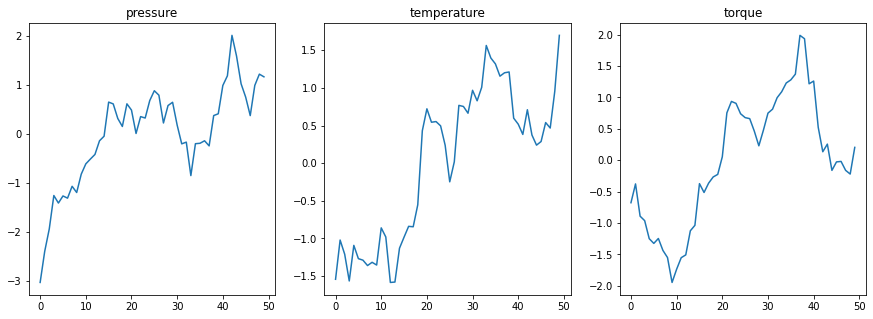

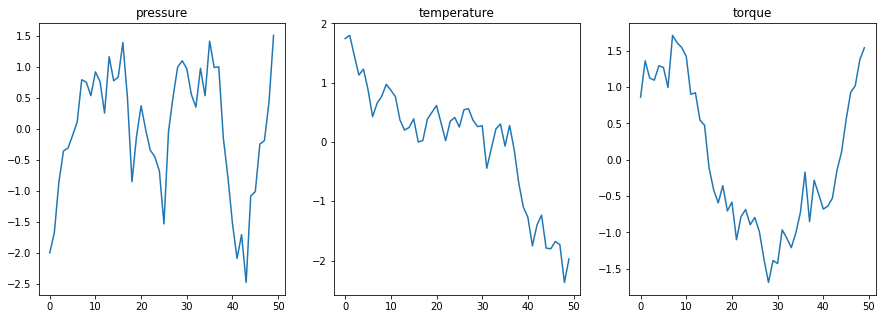

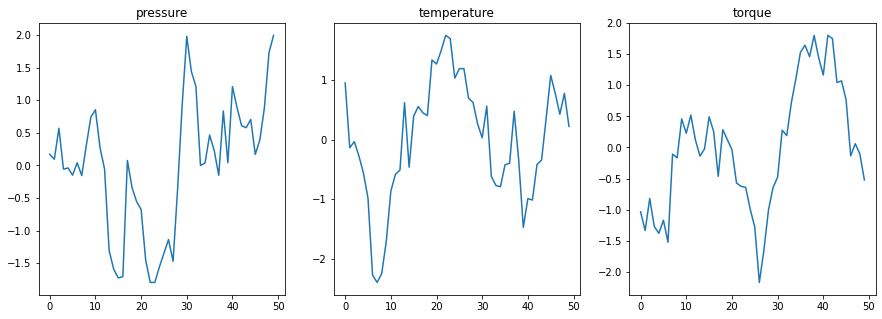

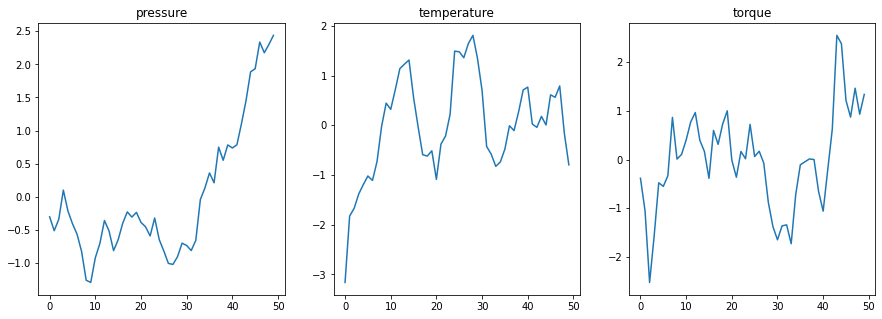

anamoly


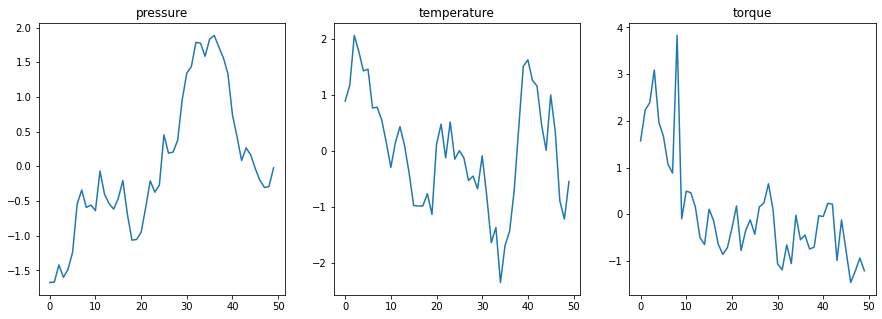

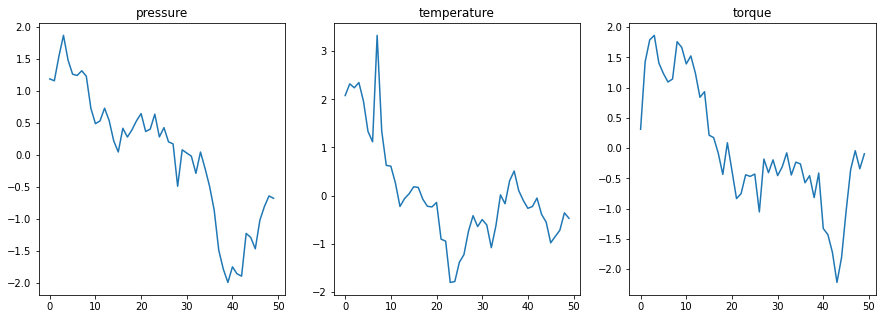

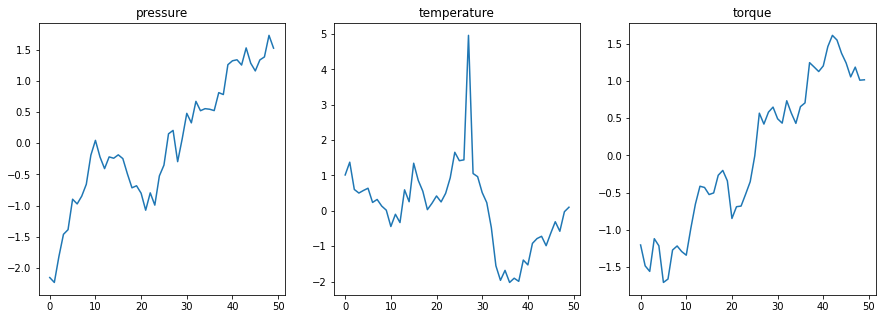

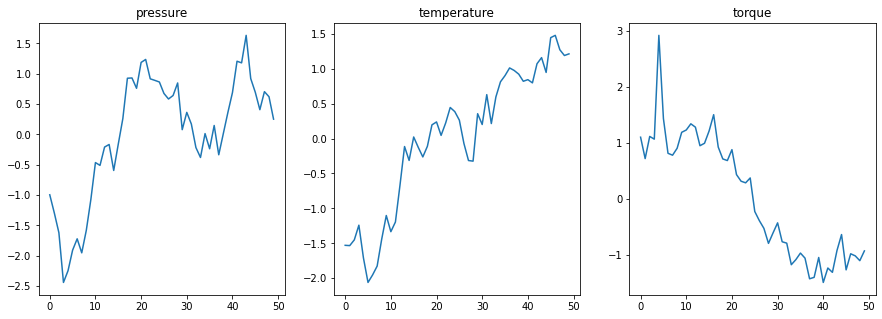

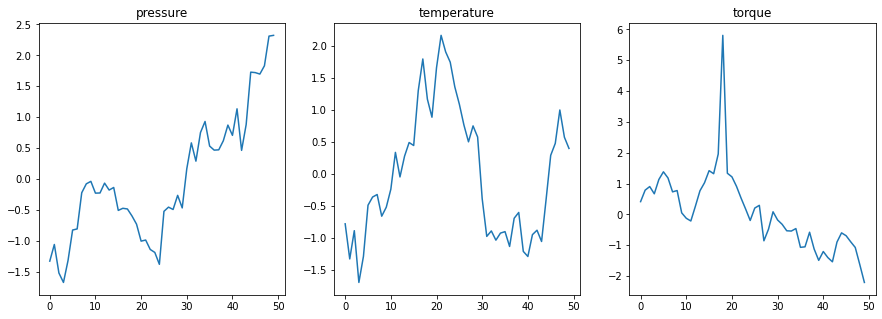

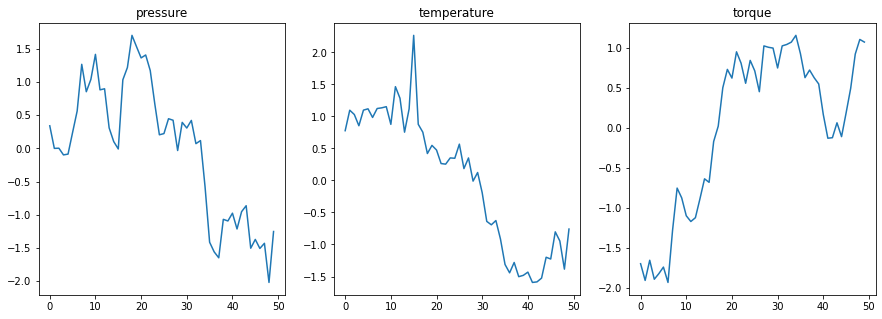

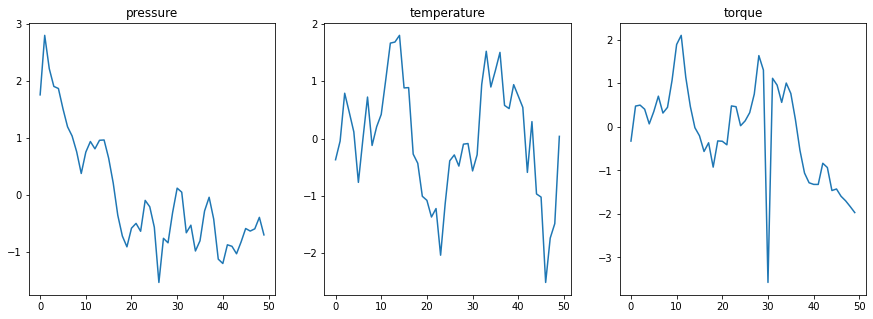

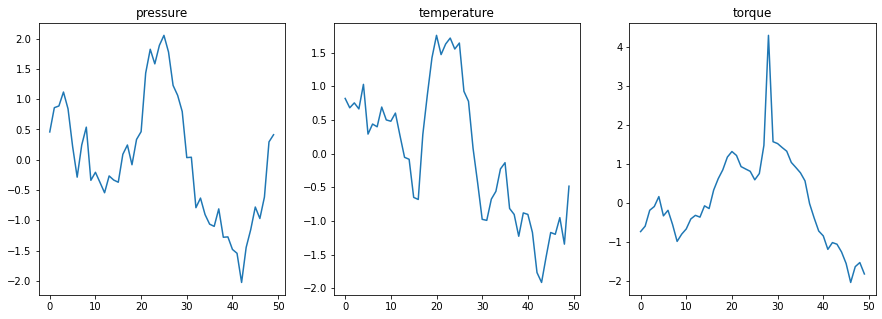

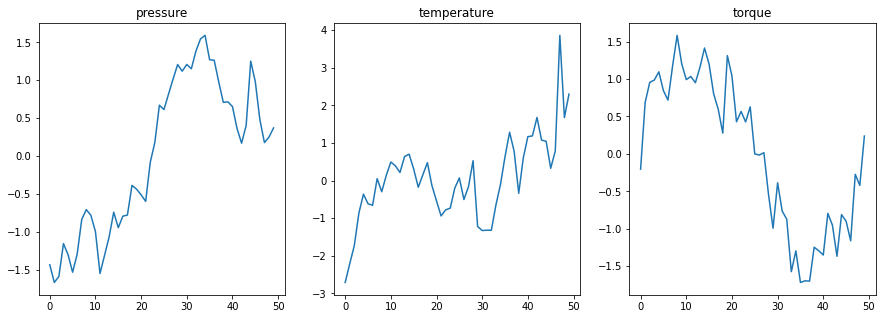

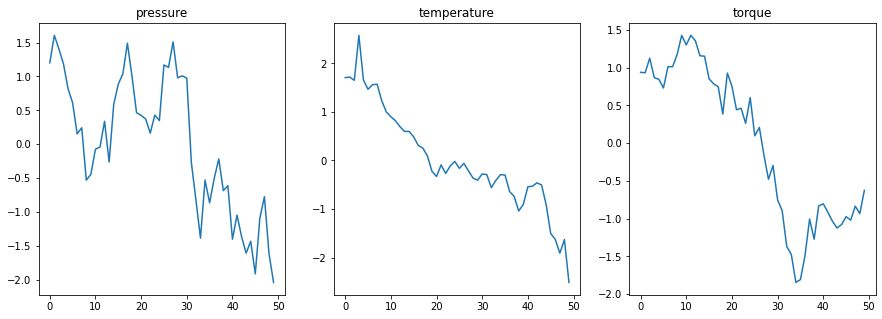

In [42]:
np.random.seed(0)
for i,class1 in enumerate(classes):
  print(class1)
  indexes = np.where(train_labels==i)[0]
  for _ in range(10):
    random_index = np.random.choice(indexes)
    plot_sample(train_inputs[random_index])

In [7]:
class mydataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = labels

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.inputs[index]
    label = self.labels[index]
    return input,label


train_inputs, val_inputs, train_labels, val_labels, = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)

train_dataset = mydataset(train_inputs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

val_dataset = mydataset(val_inputs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

test_dataset = mydataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## define the network

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(3, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(176, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net().to(device)

In [9]:
#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epoch: 5, train loss: 0.458, val loss: 0.451
epoch: 10, train loss: 0.455, val loss: 0.455
epoch: 15, train loss: 0.443, val loss: 0.432
epoch: 20, train loss: 0.236, val loss: 0.210
epoch: 25, train loss: 0.134, val loss: 0.150
epoch: 30, train loss: 0.108, val loss: 0.110
epoch: 35, train loss: 0.085, val loss: 0.089
epoch: 40, train loss: 0.076, val loss: 0.081
epoch: 45, train loss: 0.071, val loss: 0.086
epoch: 50, train loss: 0.069, val loss: 0.075

Finished Training


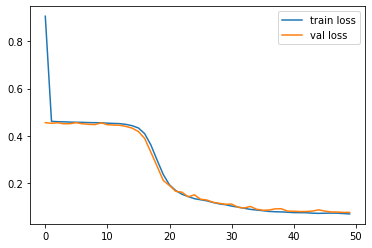

In [10]:
batch_avgTrainLoss = []
batch_avgValLoss = []

for epoch in tqdm(range(50)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []
    
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_loader):
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
    
    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_loader):
      with torch.no_grad():
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())    
        
    avg_trainLoss = sum(train_loss) / len(train_loss)
    avg_valLoss = sum(val_loss) / len(val_loss)
    batch_avgTrainLoss.append(avg_trainLoss)
    batch_avgValLoss.append(avg_valLoss)

    # print statistics
    if epoch % 5 == 4:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

print('Finished Training')
plt.plot(batch_avgTrainLoss, label='train loss')
plt.plot(batch_avgValLoss, label='val loss')
plt.legend()

evaluate

In [11]:
def evaluate(data_loader):
  y_true= []
  y_pred = []
  net.eval()

  for _, (inputBatch,labelBatch) in enumerate(data_loader):
    with torch.no_grad():
      inputBatch = inputBatch.float()
      labelBatch = labelBatch.type(torch.LongTensor)
      inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
      outputBatch = net(inputBatch)
      
      for output,label in zip(outputBatch,labelBatch):
        output, label = output.cpu(), label.cpu()
        y_true.append(label)
        pred = np.argmax(output)
        y_pred.append(pred)

  print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [12]:
print("evaluation results on train data")
evaluate(train_loader)
print("evaluation results on test data")
evaluate(test_loader)

evaluation results on train data
              precision    recall  f1-score   support

      normal     0.9817    0.9948    0.9882     31191
     anamoly     0.9723    0.9085    0.9394      6309

    accuracy                         0.9803     37500
   macro avg     0.9770    0.9517    0.9638     37500
weighted avg     0.9802    0.9803    0.9800     37500

evaluation results on test data
              precision    recall  f1-score   support

      normal     0.9797    0.9943    0.9870      8304
     anamoly     0.9701    0.8992    0.9333      1696

    accuracy                         0.9782     10000
   macro avg     0.9749    0.9468    0.9601     10000
weighted avg     0.9781    0.9782    0.9779     10000



## Patches

function to return patch

In [47]:
def patch_sample(sample, window_size=10, stride=5):

  patches = []
  
  input = sample[0][:3]
  label = sample[1]
  n_patches = int((len(input[0]) - window_size)/stride + 1)

  for i in range(n_patches):

    channels = []
    start = stride*i
    end   = stride*i + window_size

    for channel in input:
      values = []
      indicator = []
      for i in range(sample_len):
        if (i in range(start,end)) and not (np.isnan(channel[i])):
          values.append(channel[i])
          indicator.append(1)
        else:
          values.append(0)
          indicator.append(0)
      channels.append(values)

    channels.append(indicator)
    patches.append((channels,label))

  return patches

In [48]:
def patch_dataset(data):
  data1 = []
  for sample in data:
    data1.append(patch_sample(sample))
  data1 = [patch for patches in data1 for patch in patches]
  return data1

create patches data

In [62]:
train_patchData = patch_dataset(train_data)
test_patchData = patch_dataset(test_data)

In [63]:
train_patchInputs, train_patchLabels = list(zip(*train_patchData))
test_patchInputs, test_patchLabels = list(zip(*test_patchData))

train_patchInputs = np.array(train_patchInputs)
test_patchInputs = np.array(test_patchInputs)

train_patchLabels = np.array(train_patchLabels, dtype=int)
test_patchLabels = np.array(test_patchLabels, dtype=int)

In [64]:
train_patchInputs, val_patchInputs, train_patchLabels, val_patchLabels, = train_test_split(train_patchInputs, train_patchLabels, test_size=0.25, random_state=0)

train_patchDataset = mydataset(train_patchInputs, train_patchLabels)
train_patchLoader = DataLoader(train_patchDataset, batch_size=100, shuffle=True)

val_patchDataset = mydataset(val_patchInputs, val_patchLabels)
val_patchLoader = DataLoader(val_patchDataset, batch_size=100, shuffle=False)

test_patchDataset = mydataset(test_patchInputs, test_patchLabels)
test_patchLoader = DataLoader(test_patchDataset, batch_size=100, shuffle=False)

create network

In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(176, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [70]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epoch: 5, train loss: 0.451, val loss: 0.452
epoch: 10, train loss: 0.424, val loss: 0.420
epoch: 15, train loss: 0.405, val loss: 0.408
epoch: 20, train loss: 0.402, val loss: 0.403
epoch: 25, train loss: 0.400, val loss: 0.402
epoch: 30, train loss: 0.399, val loss: 0.400

Finished Training


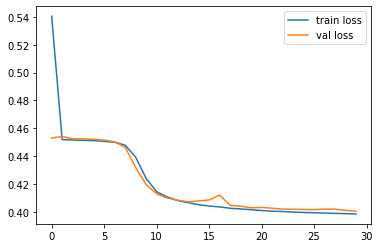

In [71]:
batch_avgTrainLoss = []
batch_avgValLoss = []

for epoch in tqdm(range(30)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []
    
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_patchLoader):
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
    
    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_patchLoader):
      with torch.no_grad():
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())    
        
    avg_trainLoss = sum(train_loss) / len(train_loss)
    avg_valLoss = sum(val_loss) / len(val_loss)
    batch_avgTrainLoss.append(avg_trainLoss)
    batch_avgValLoss.append(avg_valLoss)

    # print statistics
    if epoch % 5 == 4:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

print('Finished Training')
plt.plot(batch_avgTrainLoss, label='train loss')
plt.plot(batch_avgValLoss, label='val loss')
plt.legend()

In [72]:
print("evaluation results on train data")
evaluate(train_patchLoader)
print("evaluation results on test data")
evaluate(test_patchLoader)

evaluation results on train data
              precision    recall  f1-score   support

      normal     0.8569    0.9990    0.9225    281165
     anamoly     0.9711    0.1670    0.2850     56335

    accuracy                         0.8601    337500
   macro avg     0.9140    0.5830    0.6038    337500
weighted avg     0.8759    0.8601    0.8161    337500

evaluation results on test data
              precision    recall  f1-score   support

      normal     0.8548    0.9991    0.9213     74736
     anamoly     0.9739    0.1688    0.2877     15264

    accuracy                         0.8583     90000
   macro avg     0.9143    0.5839    0.6045     90000
weighted avg     0.8750    0.8583    0.8138     90000

